Итак, хотелось бы рассмотреть прекрасную библеотеку по прогнозирование временных рядов **Prophet**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from random import randint

##Прогнозирование временных рядов

Для начала стоит сказать пару слов о самой задаче. Предположим, что с общими терминами и идеями машинного обучения большинство уже знакомо, поэтому перейдем сразу к специфике нашей задачи.


Итак... Что же такое временные ряды?

***Временной ряд — значения меняющихся во времени признаков,
полученных в некоторые моменты времени***


То есть, по сути у нас есть набор значений и временных меток.
P.S. Не всегда, они могут быть обозначены как таковые. Например, их может просто не быть или их могут обозначать номера от 1 до n. Сути это не меняет, к тому же задачу можно свести к исходной постановке просто взяв начальную точку ряда (первое значение в "хронологическом" порядке) за какую-то дату и от нее уже вести расчет

Рассмотрим на примере датасета от [Amazon c ценой акций с 1999 по 2022 год](https://www.kaggle.com/datasets/sriharshaeedala/amazon-stock-price-from-1999-to-2022) со следующим описанием:


*   **Date**: Конкретная дата записи биржевых данных.
*   **Open**: Цена открытия акций Amazon в этот торговый день.
*   **High**: Самая высокая цена акций Amazon в течение торгового дня.
*   **Low**: Самая низкая цена акций Amazon в течение торгового дня.
*   **Close**: Цена закрытия акций Amazon на данный торговый день.
*   **Adjusted Close**: Скорректированная цена закрытия с учетом дивидендов, разделения и других корпоративных действий.
*   **Volume**: Объем торгов на указанную дату






In [ ]:
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])
amazon_df

Date       Open       High        Low      Close  Adj Close  \
0    1999-01-04   2.730729   2.966667   2.665625   2.957813   2.957813   
1    1999-01-05   2.739063   3.243750   2.662500   3.112500   3.112500   
2    1999-01-06   3.409375   3.509375   3.350000   3.450000   3.450000   
3    1999-01-07   3.428125   4.006250   3.325000   3.971875   3.971875   
4    1999-01-08   4.606250   4.978125   3.800000   4.006250   4.006250   
...         ...        ...        ...        ...        ...        ...   
6034 2022-12-23  83.250000  85.779999  82.930000  85.250000  85.250000   
6035 2022-12-27  84.970001  85.349998  83.000000  83.040001  83.040001   
6036 2022-12-28  82.800003  83.480003  81.690002  81.820000  81.820000   
6037 2022-12-29  82.870003  84.550003  82.550003  84.180000  84.180000   
6038 2022-12-30  83.120003  84.050003  82.470001  84.000000  84.000000   

          Volume  
0      785844000  
1     1257464000  
2      723532000  
3      945492000  
4     1333244000  
...          ...  
6034    57433700  
6035    57284000  
6036    58228600  
6037    54995900  
6038    62401200  

[6039 rows x 7 columns]

Ряды также делятся на одномерные и многомерные. Ряд разывается одномерным, если признак один (скажем только **Open** в нашем датасете)	, иначе — многомерным. И соответсвенно также в обоих случаях присутствует набор временных меток. В нашем случае это **Date**. В большинстве задач речь чаще всего идет именно об одномерных рядах, поэтому будем рассматривать на их примере. Посмотрим на график для ряда **Open**

In [ ]:
fig = px.line(amazon_df, x='Date', y='Open', title='Временной ряд Open')

fig.update_xaxes(title_text='Дата', nticks=25)
fig.update_yaxes(title_text='Open')
fig.update_layout(showlegend=False)

fig.show()

Очевидно, что когда-то этот ряд с данными закончится и нам нужно будет предсказывать дальнейшие значения на заданный промежуток времени. Эта задача и называется прогназированием временных рядов. ***Построить функцию f, которая как можно лучше приближает значение на предсказательном интервале.*** Более формально определения ML задачи звучит как:

***Прогнозирование временных рядов — это специальный случай задачи регрессии, в которой объекты выборки линейно упорядочены по времени. Обучающая выборка находится в прошлом, тестовая — в будущем.***


То есть, общий алгоритм действий от простой задачи регрессии не менятся, берем исходные данные, делим на test/train выборки. Затем обучаем модель и тестируем. В итоге должна получиться примерно такая картина:

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=amazon_df[:5000]['Date'], y=amazon_df[:5000]['Open'], name = "Обучающая выборка", mode='lines'))
fig.add_trace(go.Scatter(x=amazon_df[5000:]['Date'], y=amazon_df[5000:]['Open'] + [randint(-10, 10) for i in range(1039)], name = "Предсказание", mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(x=amazon_df[5000:]['Date'], y=amazon_df[5000:]['Open'], name = "Тестовая выборка", mode='lines', line=dict(color='orange')))

fig.update_layout(title='Временной ряд Open')
fig.update_xaxes(title_text='Дата', nticks=25)
fig.update_yaxes(title_text='Open')
fig.update_layout(showlegend=True)

fig.show()

Не будем сейчас останавливаться на конкретных алгоритмах. Скажем только про метрики

**Метрики**

В целом, метрики ничем не отличаются от стандартных метрик для задач регрессии. Так что не будем изорящться и в рамках данного обзора будем тестировать по 3 стандартным метрикам для регрессии, так как исходный результат легко оценить и по существующим:

*   **MAE** (Средняя абсолютная ошибка) MAE = 1/n * Σ|y_i - ŷ_i|

*   **RMSE** (Квадрат среднеквадратичной ошибки) RMSE = √(1/n * Σ(y_i - ŷ_i)²)

*   **MAPE** (Средняя абсолютная ошибка в процентах) MAPE = 100%/n * Σ|y_i - ŷ_i| / y_i







# Prophet

##Установка

На текущий момент у библеотеки Prophet имеется две реализации: R и Python. На R она устанавливается с помощью CRAN и команды

```
install.packages('prophet')

```


Мы соответственно будем рассматривать реализацию на питоне. Тут она тоже устанавливается с помощью стандартных методов и пакетных менеджеров. То есть или через PyPI

```
pip install prophet
```
Или через Anacoda среду


```
conda install -c conda-forge prophet

```



Дальнейшая настройка не требуется, все работает "из коробки". Существует лишь ряд из нескольких системных ограничений:


*   Начиная с версии 0.6, Python 2 больше не поддерживается.
*   Начиная с версии 1.0, имя пакета в PyPI - “prophet”; до версии 1.0 это было “fbprophet”.
*   Начиная с версии 1.1, минимальная поддерживаемая версия Python - 3.7.





##Общий обзор

Теперь приступим уже к обзору самой библиотеки. Краткое описание гласит:

***Prophet - это программное обеспечение с открытым исходным кодом, выпущенное командой Facebook по анализу данных.***

Но, конечно, основной фокус тут сделан именно на временных рядах. Главная страница встречает нас следующими достоинствами библиотеки:

"*Prophet - это процедура прогнозирования данных временных рядов на основе аддитивной модели, в которой нелинейные тренды согласуются с годовой, еженедельной и ежедневной сезонностью, а также с эффектами праздников. Лучше всего она работает с временными рядами, которые имеют сильные сезонные эффекты, и с историческими данными за несколько сезонов. Prophet устойчив к отсутствию данных и изменениям тренда и, как правило, хорошо справляется с выбросами.*"

Что достаточно интересно. Так как "*в простых задачах из области эконометрики поведение временного ряда складывается из медленно меняющегося тренда, сезонной квазипериодичности и различных календарных эффектов*". Так что по словам разработчика, именно на таких задачах библеотека и должна показывать наибольшее превосходство над аналогами. В дальнейшем попробуем проверить правдивость слов Facebook

Посмотрим на основное содержимое библиотеки

In [ ]:
import prophet

In [ ]:
#Оставил только интересующий нас вывод команды
help(prophet)

PACKAGE CONTENTS
    __version__
    diagnostics
    forecaster
    make_holidays
    models
    plot
    serialize
    tests (package)
    utilities


Заметим, что уже даже по структуре модулей библеотеки можно понять, что она имеет достаточно обширный спект возможностей. От диагностики до ручного добавления сезонностей и точек перелома. И еще множество функций описанных в документации.

НО, начнем с базового примера использования

Импортируем основную библиотеку и готовим данные

In [20]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]

Затем создаем обьект модели и запускаем обучение. В среднем, по словам авторов, оно занимает от 1 до 5 секунд. У меня заняло 2 в данной задаче

In [19]:
prf = Prophet()
prf.fit(amazon_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/59h9t2j4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/1dh7sr7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15723', 'data', 'file=/tmp/tmp1vxbavm4/59h9t2j4.json', 'init=/tmp/tmp1vxbavm4/1dh7sr7o.json', 'output', 'file=/tmp/tmp1vxbavm4/prophet_modelk4m9aa95/prophet_model-20231127140808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:08:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Готово! Модель обучена и может применяться для предсказаний. Вот так просто. Попробуем теперь применить ее для предсказаний, а именно цены акций на следующий год. Для этого в библиотеке предусмотрен модуль для автоматической генерации запроса на определенный период. Зададим год и посмотрим на результат

In [21]:
future = prf.make_future_dataframe(periods=365, include_history = False)
future

ds
0   2022-12-31
1   2023-01-01
2   2023-01-02
3   2023-01-03
4   2023-01-04
..         ...
360 2023-12-26
361 2023-12-27
362 2023-12-28
363 2023-12-29
364 2023-12-30

[365 rows x 1 columns]

In [22]:
result = prf.predict(future)
result

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2022-12-31  163.706090  147.139703  178.311180   163.706090   163.706090   
1   2023-01-01  163.755621  146.531702  178.276352   163.755621   163.755621   
2   2023-01-02  163.805151  148.863113  178.397041   163.805151   163.805151   
3   2023-01-03  163.854682  146.662718  178.432246   163.854682   163.854682   
4   2023-01-04  163.904213  147.907712  179.443175   163.904213   163.904213   
..         ...         ...         ...         ...          ...          ...   
360 2023-12-26  181.537160  164.059434  195.290018   180.166348   182.709733   
361 2023-12-27  181.586690  164.179834  195.839878   180.210427   182.763996   
362 2023-12-28  181.636221  163.290886  195.727597   180.254602   182.819047   
363 2023-12-29  181.685752  163.335025  195.777263   180.298776   182.879085   
364 2023-12-30  181.735283  163.835352  195.128483   180.342951   182.935888   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0         -1.160826             -1.160826             -1.160826 -0.132285   
1         -0.966975             -0.966975             -0.966975 -0.132285   
2         -0.539030             -0.539030             -0.539030  0.107181   
3         -0.408028             -0.408028             -0.408028  0.057857   
4         -0.206989             -0.206989             -0.206989  0.089267   
..              ...                   ...                   ...       ...   
360       -1.956433             -1.956433             -1.956433  0.057857   
361       -1.752784             -1.752784             -1.752784  0.089267   
362       -1.595179             -1.595179             -1.595179  0.064074   
363       -1.522653             -1.522653             -1.522653 -0.053808   
364       -1.406174             -1.406174             -1.406174 -0.132285   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0       -0.132285     -0.132285 -1.028541     -1.028541     -1.028541   
1       -0.132285     -0.132285 -0.834690     -0.834690     -0.834690   
2        0.107181      0.107181 -0.646211     -0.646211     -0.646211   
3        0.057857      0.057857 -0.465885     -0.465885     -0.465885   
4        0.089267      0.089267 -0.296256     -0.296256     -0.296256   
..            ...           ...       ...           ...           ...   
360      0.057857      0.057857 -2.014289     -2.014289     -2.014289   
361      0.089267      0.089267 -1.842051     -1.842051     -1.842051   
362      0.064074      0.064074 -1.659253     -1.659253     -1.659253   
363     -0.053808     -0.053808 -1.468845     -1.468845     -1.468845   
364     -0.132285     -0.132285 -1.273889     -1.273889     -1.273889   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
360                   0.0                         0.0   
361                   0.0                         0.0   
362                   0.0                         0.0   
363                   0.0                         0.0   
364                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
0                           0.0  162.545264  
1                           0.0  162.788646  
2                           0.0  163.266122  
3                           0.0  163.446654  
4                           0.0  163.697224  
..                          ...         ...  
360                         0.0  179.580727  
361                         0.0  179.833906  
362                         0.0  180.041042  
363                         0.0  180.163099  
364                         0.0  180.329108  

[365 rows x

Тут достаточно много разных колонок и значений. Нас пока они не интересуют, лишь сам прогноз. Посмотрим на него и отобразим на графике

In [23]:
result = result[['ds', 'yhat']]

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=amazon_df['ds'], y=amazon_df['y'], name = "Обучающая выборка", mode='lines'))
fig.add_trace(go.Scatter(x=result['ds'], y=result['yhat'], name = "Предсказание", mode='lines', line=dict(color='green')))


fig.update_layout(title='Временной ряд Open')
fig.update_xaxes(title_text='Дата', nticks=25)
fig.update_yaxes(title_text='Open')
fig.update_layout(showlegend=True)

fig.show()

Возникают некоторые вопросы... Может быть мы что-то перепутали? Хорошо, что в библиотеке есть встроенные методы для визуализации, которые мы можем запустить и проверить почему так получилось

In [25]:
from prophet.plot import plot_plotly, plot_components_plotly

future = prf.make_future_dataframe(periods=365, include_history = True)
result = prf.predict(future)

plot_plotly(prf, result)

И заметим, что в целом он вполне верно определил тренд, а это неожиданное падение в 2022 просто слишком из него выбивается(опять же, что поделать, не всегда данные имеют одинаковый тренд на всем промежутке). Да и в целом, данные не идельные. Тренд сильно меняется к концу обучающей выборки, так что процентов **60** ее остаются вне вот этого резкого подьема. А на модель 60% влияют еще как...

Хорошо, тогда для теста возьмем все данные по дням до 2014 года, 2014 год используем как тестовую выборку и проверим на ней качество нашей модели

In [ ]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]

In [ ]:
train = amazon_df[amazon_df['ds'] < '2014-01-01']
test = amazon_df[(amazon_df['ds'] >= '2014-01-01') & (amazon_df['ds'] < '2015-01-01')]

In [ ]:
model = Prophet()
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0zki05qv/2evccl5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0zki05qv/rzj6aama.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15933', 'data', 'file=/tmp/tmp0zki05qv/2evccl5l.json', 'init=/tmp/tmp0zki05qv/rzj6aama.json', 'output', 'file=/tmp/tmp0zki05qv/prophet_modelyjm5bp93/prophet_model-20231127024922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:49:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
result = model.predict(test[['ds']])
result = result[['ds', 'yhat']]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], name = "Обучающая выборка", mode='lines'))
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], name = "Тестовая выборка", mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(x=result['ds'], y=result['yhat'], name = "Предсказание", mode='lines', line=dict(color='orange')))

fig.update_layout(title='Временной ряд Open')
fig.update_xaxes(title_text='Дата', nticks=25)
fig.update_yaxes(title_text='Open')
fig.update_layout(showlegend=True)

fig.show()

In [ ]:
test['predict'] = list(result['yhat'])

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
mae = mean_absolute_error(test['y'], test['predict'])
rmse = mean_squared_error(test['y'], test['predict'], squared=False)
mape = mean_absolute_percentage_error(test['y'], test['predict'])
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape*100}%")

MAE: 1.818016225114761
RMSE: 2.1498892843453965
MAPE: 10.9397423816616%


Вот, это уже достаочно неплохо. Мы буквально за 3 секнуды получили предсказания с отклонением не больше 10%. Достойно. Теперь сохраним модель

In [ ]:
from prophet.serialize import model_to_json

with open('model.json', 'w') as fout:
    fout.write(model_to_json(model))

##Продвинутая настройка Prophet

Когда мы разобрались с основынми концепциями, можно перейти к более подробному разбору возможностей Prophet. Здесь я имею ввиду образец класса `Prophet()`, то есть посомторим на возможности самой модели

In [ ]:
help(Prophet())

Тут достаточно обширный набор всех параметров и функций, которые порой отвечают за крайне специфические задачи. Так что о них можно более подробно прочитать в документации, а сейчас мы остановимся на наиболее важных и интересных

###**1**. Специфика вызова

Общий принцип работы авторы взяли от Sklearn. То есть мы создаем один обьекь класса `Prophet` и далее вызваем `fit`, `predict` и другие методы уже от него.


Более того, сайт говорит нам:

"Входными данными для Prophet всегда является фрейм данных с двумя столбцами: `ds` и `y`. Столбец `ds` (метка даты) должен иметь формат, ожидаемый Pandas, в идеале ГГГГ-ММ-ДД для даты или ГГГГ-ММ-ДД ЧЧ:ММ:СС для метки времени. Столбец `y` должен быть числовым и представлять измерение, которое мы хотим спрогнозировать"

Требование про формат данных для предсказа ния достаточно очевидно, да и в целом тут ничего интересного. Единственное что, предполагается одномерный ряд для предсказания на вход. И что предобработку данных под формат библиотеки мы должны выполнить сами. К примеру, выше я делал это с помощью строк:


```
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
```



###**2**. Growth trend и Saturating

Одном из основных параметров `Prophet()` является `growth`. Он определяет общий принцип тренда. В библиотеке имеем следующее описание:

"*growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or flat trend.*"

*   **linear** - Линейная модель роста (тренда). Возможны некоторые колебания, но линейность тренда не меняется
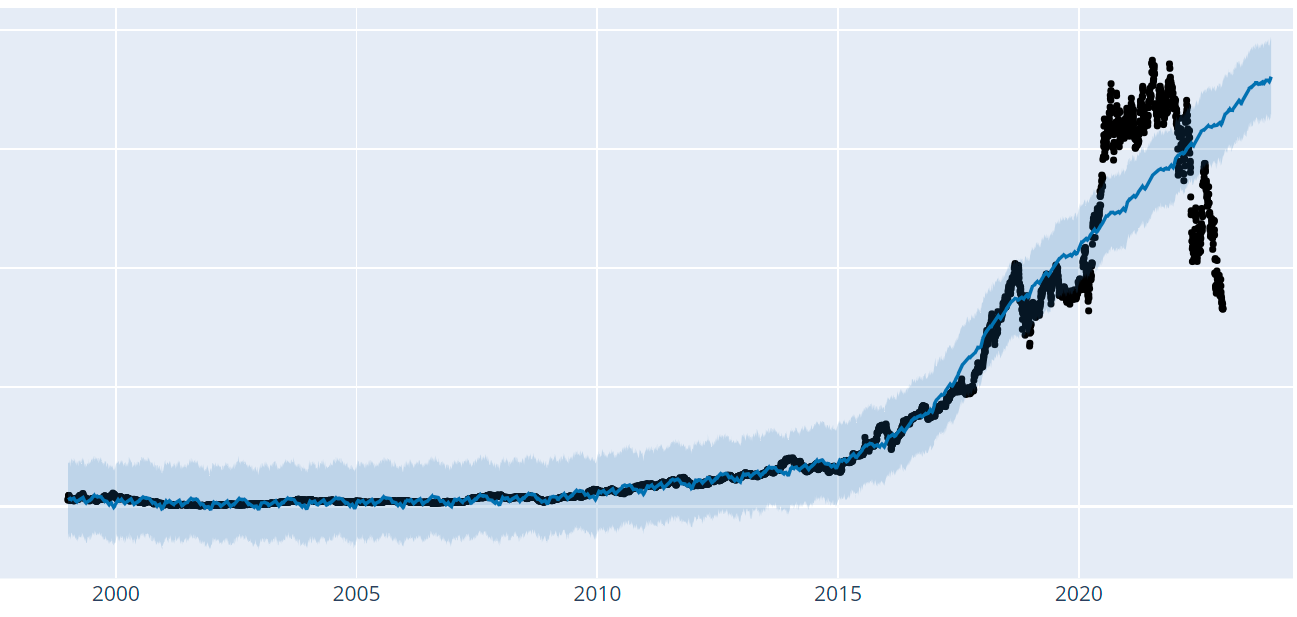
*   **flat** - Около-горизонтальный тренд с колебаниями в ту или иную сторну. Чаще всего с синусоидные колебаниями.
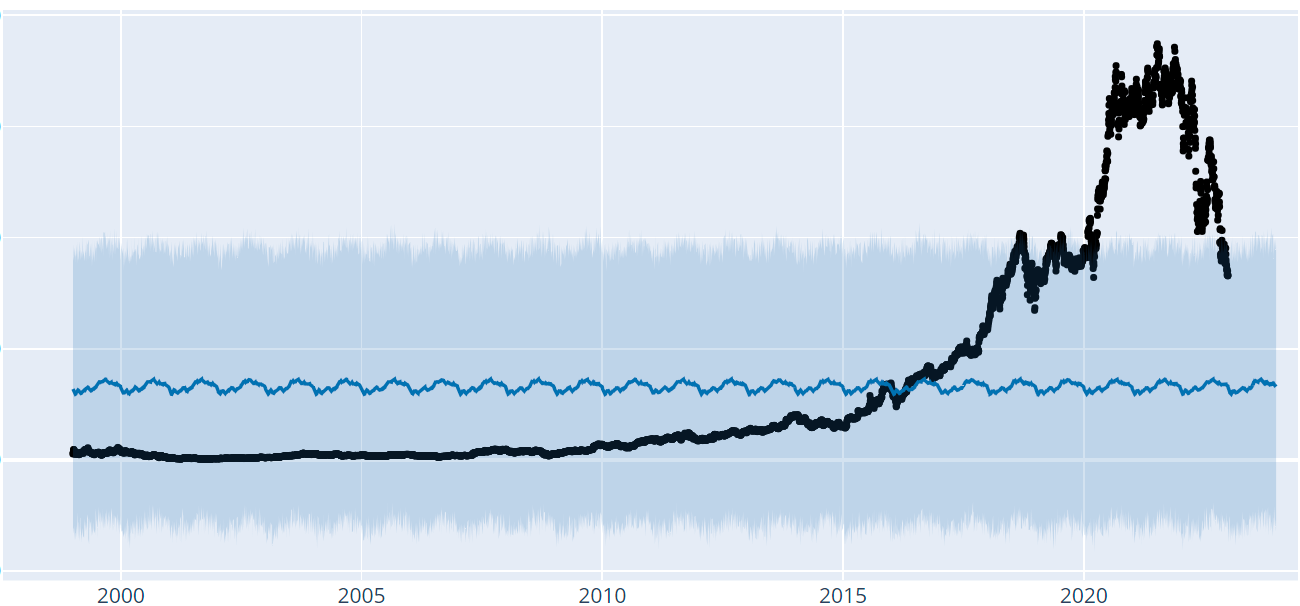
*   **logistic**

По умолчанию стоит значение `linear` и оно будет вполне акутальным. Так как в случае, если линия будет почти горизонтальной с колебаниями, то это все равно будет оставаться не самым плохим вариантом. Но в целом, этот параметр должен выбираться пользователем исходя из обзора данных.


Но есть еще один случай, когда у нас заранее известены максимально/минимально достижимые значения. Тогда при приближении к ним рост должен как-бы стагнировать или "насыщаться". Это и называется **Saturating**.

Для этого нам нужно просто добавить колонку

```
df['cap'] = max_value

```
Значение должно выбираться пользователем исходя из дополнительных знаний. Например, анализа предметной области, сторонних данных, ручной аналитики. Для всех данных тут все субьективно.

И затем нам остается просто применить логистическую модель роста (параметр `logistic`). Так как для нее нам и как раз требуются ограничения для нормировки значений между 0 и 1 (внутри модели). Посмотрим на примере нашего датасета, возьмем в качестве макс. значения **190**.


In [38]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]
amazon_df['cap'] = 190

In [41]:
prf = Prophet(growth = 'logistic')
prf.fit(amazon_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/j_ymj3kz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/wgklxzia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6116', 'data', 'file=/tmp/tmp1vxbavm4/j_ymj3kz.json', 'init=/tmp/tmp1vxbavm4/wgklxzia.json', 'output', 'file=/tmp/tmp1vxbavm4/prophet_modelqgh83z0a/prophet_model-20231127153353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:33:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [42]:
from prophet.plot import plot_plotly, plot_components_plotly

future = prf.make_future_dataframe(periods=1460, include_history = True)
future['cap'] = 190
result = prf.predict(future)

plot_plotly(prf, result)

Как видно, даже на длительном периоде предсказаний наблюдается рост, но он не превосходит заданный потолок. В случае если бы мы его не задавали, рост не был бы ничем ограничен. Пример ниже:

In [ ]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]
prf = Prophet(growth = 'linear')
prf.fit(amazon_df)
future = prf.make_future_dataframe(periods=1460, include_history = True)
result = prf.predict(future)

In [44]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(prf, result)

И аналогично, если мы хотим ограничить наш убывающий тренд снизу, то надо использовать


```
df['floor'] = min_value
```



###**3.** Trend Changepoints и Seasonality

Возможно, вы заметили в предыдущих примерах в этой документации, что Траектории временных рядов часто меняются. Даже на нашем исходном ряде это заметно (особенно ближе к концу). Существуют даже подобные ряды (тоже из исходного датасета)

In [62]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Volume']
amazon_df = amazon_df[['ds', 'y']]

In [65]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=amazon_df['ds'], y=amazon_df['y'], name = "Обучающая выборка", mode='lines'))

fig.update_layout(title='Временной ряд Open')
fig.update_xaxes(title_text='Дата', nticks=25)
fig.update_yaxes(title_text='Volume')
fig.update_layout(showlegend=False)

fig.show()

С такими резкими изменениями ряда предсказывать мягко говоря сложно. Но тренд - штука непостоянная, так что и с этим приходиться работать. Изменения траектории уже автоматически обрабатываются библиотекой, но и у нас есть способ на это повлиять.

**Как это все работает?**

Рассмотрим на примере от Facebook

Prophet определяет точки изменения, сначала указывая большое количество потенциальных точек изменения, при которых разрешено изменять курс. Затем он устанавливает разреженный приоритет для величин изменений курса (эквивалентно регуляризации L1) - по сути, это означает, что Prophet имеет большое количество возможных мест, где курс может измениться, но будет использовать как можно меньше из них. Вертикальные линии на этом рисунке указывают, где были размещены потенциальные точки изменения:



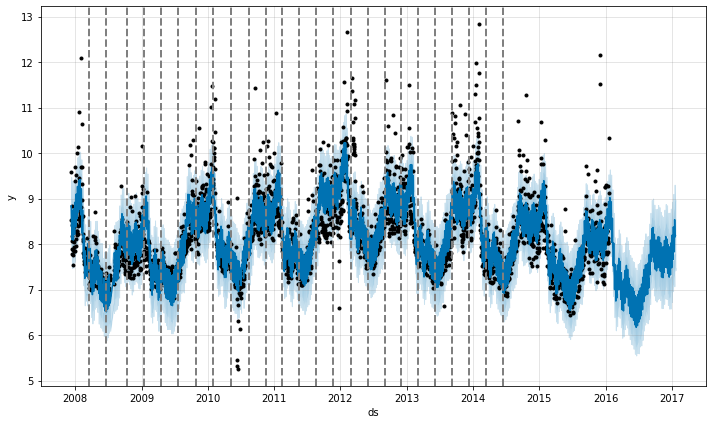

Несмотря на то, что у нас есть много мест, где курс может измениться, из-за редкого предыдущего периода большинство этих точек изменения остаются неиспользованными. Мы можем увидеть это, построив график величины изменения курса в каждой точке изменения:

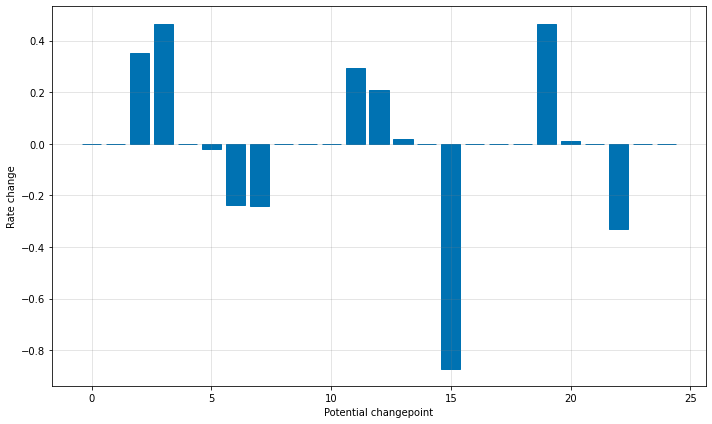

По умолчанию Prophet указывает 25 потенциальных точек изменения, которые равномерно распределены в первых 80% временного ряда.

**Как можно на это повлиять?**


*   Можно вручную задать количество потенциальных точек изменения
 с помощью параметра `n_changepoints` (**по умолчанию 25**)
*   С помощью `changepoint_range` можно изменить первые n процентов ряда, в которых мы учитваем точки изменения. По умолчанию точки изменения учитваются только для **80%** ряда, чтобы не устраивать сильные колебания курса ближе к концу.
*   `changepoint_prior_scale` вляет на "гибкость" изменения тренда. То есть на то, насколько сильно он может постпенно меняться и колебаться. По умолчанию установлено значение **0.05**, увеличение сделает тренд более гибким
*   Можно и просто вручную установить точки изменения с помощью. `changepoints=['date', ...]`. Таким образом модель сама определит все коээфиценты и потенциальные изменения будет учитвать только в этих точках. При этом найденные автоматические точки не будут использованы



Вспомним нашу первую модель из обзора и ее предсказания. Попробуем с помощью точек изменения улучшить ее результат. Напомню о проблеме, которая там была. График в конце не учитывал смену тенденции и также рос

In [ ]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]
prf = Prophet()
prf.fit(amazon_df)
future = prf.make_future_dataframe(periods=365, include_history = False)
result = prf.predict(future)
result = result[['ds', 'yhat']]

In [69]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=amazon_df['ds'], y=amazon_df['y'], name = "Обучающая выборка", mode='lines'))
fig.add_trace(go.Scatter(x=result['ds'], y=result['yhat'], name = "Предсказание", mode='lines', line=dict(color='green')))


fig.update_layout(title='Временной ряд Open')
fig.update_xaxes(title_text='Дата', nticks=25)
fig.update_yaxes(title_text='Open')
fig.update_layout(showlegend=True)

fig.show()

Попробуем изменить значения парметров так, чтобы он учитвал всю историю смены тенденций и слегка увеличим кол-во точек перемен

In [ ]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]
prf = Prophet(changepoint_range = 1, n_changepoints=30 )
prf.fit(amazon_df)
future = prf.make_future_dataframe(periods=365, include_history = False)
result = prf.predict(future)
result = result[['ds', 'yhat']]

In [74]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=amazon_df['ds'], y=amazon_df['y'], name = "Обучающая выборка", mode='lines'))
fig.add_trace(go.Scatter(x=result['ds'], y=result['yhat'], name = "Предсказание", mode='lines', line=dict(color='green')))


fig.update_layout(title='Временной ряд Open')
fig.update_xaxes(title_text='Дата', nticks=25)
fig.update_yaxes(title_text='Open')
fig.update_layout(showlegend=True)

fig.show()

Вот это уже больше похоже на правду по текущему графику. Хотя опять же, кто знает, может тут опять начнется резкий подьем и наши предсказания окажутся неверными. На таких рядах сложно о чем-то говорить.

В любом случае, результат стал намного лучше, что говорит нам о том, что данный механиз библиотеки работает

Также авторы отдельно отмечают особые достоинства своей библеотеки с расширенной работой с сезонносятми и праздниками. Давайте на них посмотрим



По работе с **праздниками** авторы дают нам крайне иформативное и короткое описание в документации. Продублирую его

Если у вас есть праздничные дни или другие повторяющиеся события, которые вы хотели бы смоделировать, вы должны создать фрейм данных для них. В нем есть два столбца (holiday и ds) и строка для каждого события праздника. Он должен включать все события, связанные с праздником, как в прошлом (если исходить из исторических данных), так и в будущем (если исходить из прогноза). Если они не повторятся в будущем, Prophet смоделирует их, а затем не включит в прогноз.

Вы также можете включить столбцы `lower_window` и `upper_window`, которые продлевают праздничные дни на `[lower_window, upper_window]` дней вокруг даты. Например, если вы хотите включить Сочельник в дополнение к Рождеству, вы бы включили `lower_window=-1, upper_window=0`. Если вы хотите использовать Черную пятницу в дополнение к Дню благодарения, вы бы включили `lower_window=0, upper_window=1`



Например добавить свой праздник можно так:


```
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

```
И затем использовать при обучении


```
m = Prophet(holidays=superbowls)
```



С помощью  `add_country_holidays` можно добавить заранее встроенные праздники для выбранной страны.



```
model = Prophet()
model.add_country_holidays(country_name='RU')
model.fit(df)
```

Например для России это даст следующие праздники:



In [94]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]

In [ ]:
model = Prophet()
model.add_country_holidays(country_name='RU')
model.fit(amazon_df)

In [97]:
model.train_holiday_names

0                                        New Year's Day
1                                         Christmas Day
2                             International Women's Day
3                           Holiday of Spring and Labor
4                                           Victory Day
5     Day of the Adoption of the Declaration of Sove...
6                     Day of consent and reconciliation
7                             Fatherland Defender's Day
8                                            Russia Day
9                                     New Year Holidays
10                                            Unity Day
dtype: object

А с помощью методов модуля ```prophet.make_holidays``` мы можем составить базу данных праздников для заданных лет и стран (с подрегионами) в необходимом для библиотеки формате

In [105]:
help(prophet.make_holidays.make_holidays_df)

Help on function make_holidays_df in module prophet.make_holidays:

make_holidays_df(year_list, country, province=None, state=None)
    Make dataframe of holidays for given years and countries
    
    Parameters
    ----------
    year_list: a list of years
    country: country name
    
    Returns
    -------
    Dataframe with 'ds' and 'holiday', which can directly feed
    to 'holidays' params in Prophet



Анналогично мы можем добавлять и эффект сезонности. В данной библиотеке она оценивается с использованием частичной суммы Фурье. Где количество слагаемых в частичной сумме (порядке) - это параметр, который определяет, насколько быстро может изменяться сезонность.
Базово у модели есть 3 параметра.
*   **yearly_seasonality**
*   **weekly_seasonality**
*   **daily_seasonality**

Думаю, очевидно на какой вид сезонностей они влияют... Могут быть установлены в 'auto', True, False или n (заданное пользователем кол-во генерируемых слагаемых Фурье). И тогда мы можем указать желаемый интервал для данного вида сезонности в нашей модели. По умолчанию установлено auto, что значит - наша модель автоматически определяет нужно ли учитывать ту или иную сезонность. Если да, то возьмет ее с ее значением по умолчанию

Можно также просмотреть на графике изменение сезонности в выбранном интервале. Сравним для year с значением по умолчанию и увеличенным в 5 раза

In [ ]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]

In [ ]:
from prophet.plot import plot_yearly
model = Prophet(yearly_seasonality=True)
model.fit(amazon_df)

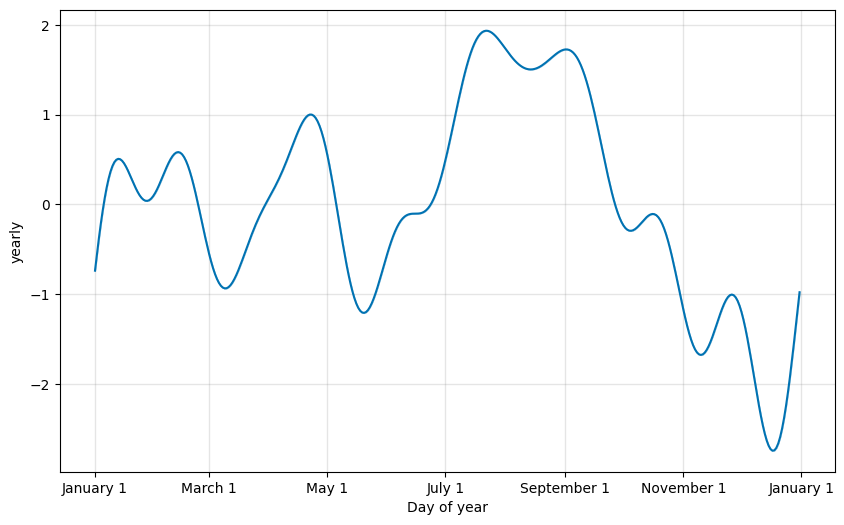

In [111]:
plot_yearly(model)

In [112]:
from prophet.plot import plot_yearly
model = Prophet(yearly_seasonality=50)
model.fit(amazon_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/r2nnqmbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/1i81zzji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4637', 'data', 'file=/tmp/tmp1vxbavm4/r2nnqmbs.json', 'init=/tmp/tmp1vxbavm4/1i81zzji.json', 'output', 'file=/tmp/tmp1vxbavm4/prophet_modelybxoai29/prophet_model-20231127181348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


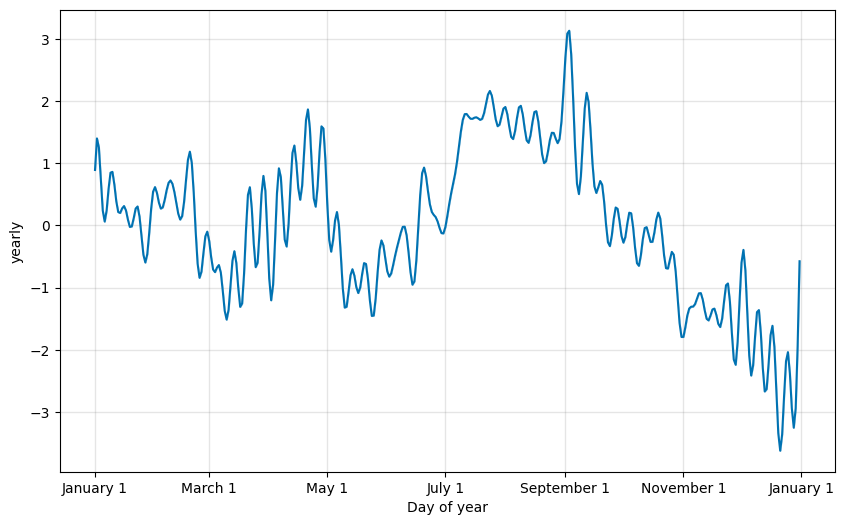

In [113]:
plot_yearly(model)

"Увеличение числа членов Фурье позволяет сезонности соответствовать быстрее меняющимся циклам, но также может привести к переобучению"
Очевидно, что и графики тоже подтверждают этот тезис

Бывают и случаи, когда сезонность хоть и сохраняется, ее влияние и коээфиценты однородно меняются с каждым годом. Как например тут:

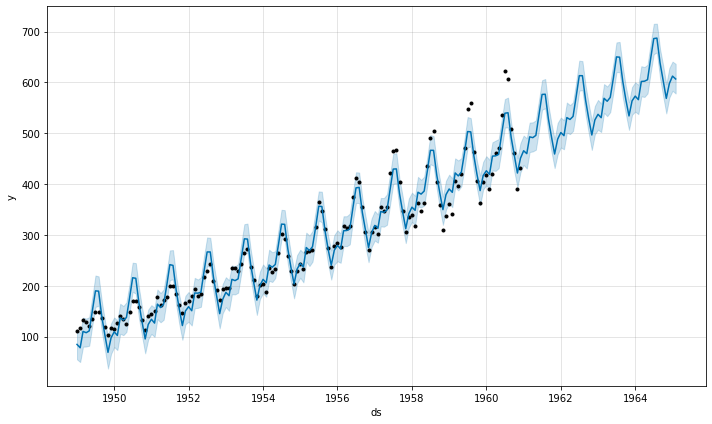

Этот временной ряд имеет четкий годовой цикл, но сезонность в прогнозе слишком велика в начале временного ряда и слишком мала в конце. В этом временном ряду сезонность не является постоянным аддитивным фактором, как предполагает Prophet, скорее она растет вместе с тенденцией. Это мультипликативная сезонность, а не аддитивная.
Ее можно обработать с помощью


```
seasonality_mode='multiplicative'
```



Существуют и другие варианты сезонностей, например добавляемые пользователем. Или те, которые действуют только в определенные периоды времни. Можно даже добавить отдельную колонку с коэффицентом по датам, которая будет работать аналогично празднику в эти даты. И все их библиотека позволяет настроить. Но это слишком уж специфические задачи, так что не будем на них останавливаться. Чаще всего невозможно их заранее определить без глубокого анализа и понимания данных. Вместо этого посмотрим как добавление сезонности повлияет на наш график из первого раздела. Возьмем немного увеличенную  годовую сезонность, чтобы эффект был заметнее. **Изначальный график без сезонности выглядел бы так:**

In [123]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]
prf = Prophet(yearly_seasonality=False)
prf.fit(amazon_df)
future = prf.make_future_dataframe(periods=365, include_history = False)
result = prf.predict(future)
result = result[['ds', 'yhat']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/1y_8mnxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/dfsi9mnq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25422', 'data', 'file=/tmp/tmp1vxbavm4/1y_8mnxm.json', 'init=/tmp/tmp1vxbavm4/dfsi9mnq.json', 'output', 'file=/tmp/tmp1vxbavm4/prophet_model07dmfja5/prophet_model-20231127182439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [124]:
from prophet.plot import plot_plotly, plot_components_plotly

future = prf.make_future_dataframe(periods=365, include_history = True)
result = prf.predict(future)

plot_plotly(prf, result)

**А с сезонностью:**

In [125]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]
prf = Prophet(yearly_seasonality=30)
prf.fit(amazon_df)
future = prf.make_future_dataframe(periods=365, include_history = False)
result = prf.predict(future)
result = result[['ds', 'yhat']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/fwlkrfcn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/9zy_rrsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44744', 'data', 'file=/tmp/tmp1vxbavm4/fwlkrfcn.json', 'init=/tmp/tmp1vxbavm4/9zy_rrsw.json', 'output', 'file=/tmp/tmp1vxbavm4/prophet_modelfaa8pde8/prophet_model-20231127182447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [126]:
from prophet.plot import plot_plotly, plot_components_plotly

future = prf.make_future_dataframe(periods=365, include_history = True)
result = prf.predict(future)

plot_plotly(prf, result)

Тут отображаются колебания, которые более естесвенно соответсвуют исходным данным, что должно повысить качество модели. Без сезонности колебаний почти не наблюдается, что чаще всего не верно

### 4. Выбросы и неопределенности

В прогнозировании самым значительным фактором неопределенности является потенциальное изменение тренда. Исторические данные показывают явные трендовые сдвиги, которые Prophet умеет определять и настраивать. Однако предсказать будущие изменения тренда сложно. Поэтому предполагается, что будущие изменения тренда будут происходить с аналогичной частотой и масштабом, как и в прошлом. Эти предположения помогают проектировать тренды в будущее и создавать интервалы неопределенности, основываясь на их распределении.

Повлиять на работу модели тут можно 2 способами:


*   Первый способ заключается в управлении неопределенностью путем изменения параметра `changepoint_prior_scale`. Увеличение этого параметра приводит к большей гибкости модели и, как следствие, к увеличению неопределенности прогноза. Это обусловлено тем, что моделирование большего числа изменений в исторических данных влечет за собой ожидание более значительных изменений в будущем, делая интервалы неопределенности ключевым индикатором возможного переобучения.
*   Второй способ – это настройка ширины интервалов неопределенности, которая по умолчанию составляет 80%. Для этого используется параметр `interval_width`.




Можно также менять неопределенность в сезонности, но это требует гораздо более сложных методов анализа и имеет более узкую направленность. Но библиотека позволяет и это

По работе с выбросами у библиотеки нет заданных инструментов. Но она позволяет упростить процесс их удаления. Если пользователь найдет выброс, он может просто вместо них установить в датасете None. Модель автоматически дозаполнит их предсказаниями и будет корректно учитывать при обучении. Например удалим 2004-2005 год. Также давайте увеличим `interval_width` до 1, чтобы была заметна разница по сравнению с исходным графиком по неопределености:

In [130]:
from prophet import Prophet
amazon_df = pd.read_csv("AMZN_data_1999_2022.csv")
amazon_df['ds'] = pd.to_datetime(amazon_df['Date'])
amazon_df['y'] = amazon_df['Open']
amazon_df = amazon_df[['ds', 'y']]
amazon_df.loc[(amazon_df['ds'] >= '2004-01-01') & (amazon_df['ds'] < '2006-01-01'), 'y'] = None
prf = Prophet(interval_width=1)
prf.fit(amazon_df)
future = prf.make_future_dataframe(periods=365, include_history = False)
result = prf.predict(future)
result = result[['ds', 'yhat']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/1d5o4bzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vxbavm4/qki_nb4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13540', 'data', 'file=/tmp/tmp1vxbavm4/1d5o4bzc.json', 'init=/tmp/tmp1vxbavm4/qki_nb4o.json', 'output', 'file=/tmp/tmp1vxbavm4/prophet_models2_1ulfp/prophet_model-20231127195106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [131]:
from prophet.plot import plot_plotly, plot_components_plotly

future = prf.make_future_dataframe(periods=365, include_history = True)
result = prf.predict(future)

plot_plotly(prf, result)

Как видно, общий прогноз особо не поменялся.


#Заключение

В библиотеке также есть много совершенно разных возможностей, о которых я не успел расказать. В основном это какие-то детали связанные с более точной настройкой модели или ее параметров. Так что о них есть смысл узнавать, если необходимо более тонко изменить какой-либо аспект обучения.

Последнее что хотел бы выделеть, это модуль `prophet.plot` В нем содержатся различные методы для визуализации работы как модели,так и библиотеки в целом, что является крайне полезным инструментом по анализу результатов работы. В чем мы могли убедиться в процессе этого обзора, так как я неоднократно прибегал к прекрасным возможностям этого модуля

В заключение хотелось бы сказать, что библиотека Prophet от Facebook представляет собой мощный инструмент для прогнозирования временных рядов, специально разработанный для обработки данных с сильными сезонными колебаниями и праздничными эффектами. Его ключевым преимущетвом я бы назвал гибкость в моделировании трендов и настройке, что позволяет оптимизировать модель под совершенно разные задачи. Я работал с библиотекой и до этого обзора, но теперь особенно понимаю почему Prophet стал таким популярным выбором среди аналитиков и разработчиков данных